<a href="https://colab.research.google.com/github/ganji759/PINNs-for-Thermoacoustic/blob/main/Research_PINN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adam Epoch [1000/5000], Loss: 0.000003
Adam Epoch [2000/5000], Loss: 0.000000
Adam Epoch [3000/5000], Loss: 0.000000
Adam Epoch [4000/5000], Loss: 0.000000
Adam Epoch [5000/5000], Loss: 0.000000
L-BFGS Epoch [1/5000], Loss: 0.000000
L-BFGS Epoch [1000/5000], Loss: 0.000000
L-BFGS Epoch [2000/5000], Loss: 0.000000
L-BFGS Epoch [3000/5000], Loss: 0.000000
L-BFGS Epoch [4000/5000], Loss: 0.000000
L-BFGS Epoch [5000/5000], Loss: 0.000000


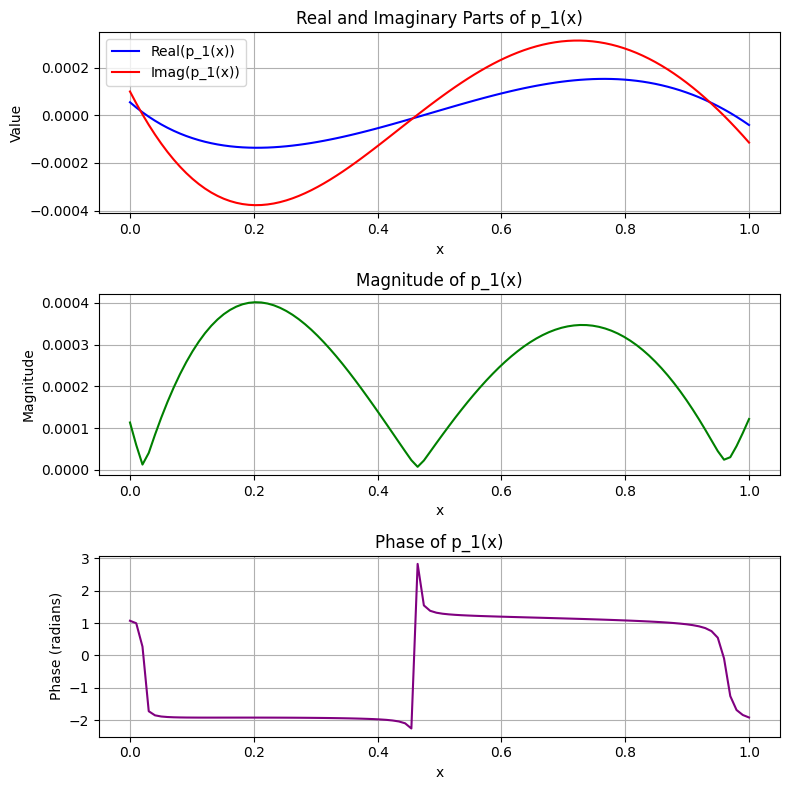

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the neural network for complex-valued output
class ComplexPINN(nn.Module):
    def __init__(self, num_hidden=32):
        super(ComplexPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, 2)  # Output real and imaginary parts
        )

    def forward(self, x):
        out = self.net(x)
        return out[:, 0:1] + 1j * out[:, 1:2]  # Complex-valued p_1(x)

# Physical constants for air
gamma = 1.4
p_m = 101325  # Pa
T_0 = 293  # K
R = 8.314  # J/mol·K
M = 0.029  # kg/mol (air)
rho_m = p_m * M / (R * T_0)  # Mean density
kappa = 0.026  # W/m·K
cp = 1005  # J/kg·K
mu = 1.81e-5  # Pa·s
omega = 2 * np.pi * 100  # rad/s (f = 100 Hz)
a = np.sqrt(gamma * R * T_0 / M)  # Speed of sound
sigma = 0.71  # Prandtl number
beta = 1 / T_0  # Thermal expansion coefficient

# Thermal and viscous penetration depths
delta_k = np.sqrt(kappa / (rho_m * cp * omega))
delta_v = np.sqrt(mu / (rho_m * omega))

# Stack properties for epsilon_s
kappa_s = 0.1  # W/m·K
rho_s = 2500  # kg/m^3
c_ps = 900  # J/kg·K
l_s = 0.01  # m
r_s = 0.001  # m
delta_s = np.sqrt(kappa_s / (rho_s * c_ps * omega))
epsilon_s = np.sqrt(kappa_s * rho_s * c_ps) * np.tanh((1 + 1j) * l_s / delta_s / r_s)
epsilon_s = torch.tensor(epsilon_s, dtype=torch.complex64)

# Complex functions f_v and f_k
r_v = r_k = 0.001  # Geometric parameter (e.g., stack spacing)
f_v = torch.tensor(np.tanh((1 + 1j) * l_s / delta_v / r_v), dtype=torch.complex64)
f_k = torch.tensor(np.tanh((1 + 1j) * l_s / delta_k / r_k), dtype=torch.complex64)

# Mean temperature gradient
grad_T = 50  # K/m
def T_m(x):
    return T_0 + grad_T * x

# Physics-informed loss function
def compute_loss(model, x, L=1.0):
    x = x.requires_grad_(True)

    p_1 = model(x)

    # Compute derivatives
    p_1_x = torch.autograd.grad(p_1, x, grad_outputs=torch.ones_like(p_1), create_graph=True)[0]
    p_1_xx = torch.autograd.grad(p_1_x, x, grad_outputs=torch.ones_like(p_1_x), create_graph=True)[0]

    # Mean temperature derivative
    dTm_dx = torch.ones_like(x) * grad_T

    # PDE terms
    term1 = (1 + (gamma - 1) / (1 + epsilon_s)) * p_1
    term2 = (a**2 / omega**2) * rho_m * (((1 - f_v) / rho_m) * p_1_xx)
    term3 = (a**2 / omega**2) * ((f_k - f_v) / ((1 + epsilon_s) * (sigma - 1))) * beta * dTm_dx * p_1_x

    pde_residual = term1 + term2 + term3
    pde_loss = torch.mean(pde_residual.abs()**2)

    # Boundary conditions: p_1(0) = p_1(L) = 0
    x_bc = torch.tensor([[0.0], [L]], requires_grad=True)
    p_1_bc = model(x_bc)
    bc_loss = torch.mean(p_1_bc.abs()**2)

    return pde_loss + bc_loss

# Training function with Adam followed by L-BFGS
def train(model, num_epochs_adam=5000, num_epochs_lbfgs=5000, num_points=1000):
    # Adam optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs_adam):
        x = torch.rand(num_points, 1)
        optimizer.zero_grad()
        loss = compute_loss(model, x)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 1000 == 0:
            print(f'Adam Epoch [{epoch+1}/{num_epochs_adam}], Loss: {loss.item():.6f}')

    # L-BFGS optimization
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, max_eval=25, tolerance_grad=1e-7, tolerance_change=1e-9, history_size=100)
    def closure():
        optimizer.zero_grad()
        x = torch.rand(num_points, 1)
        loss = compute_loss(model, x)
        loss.backward()
        return loss
    for epoch in range(num_epochs_lbfgs):
        loss = optimizer.step(closure)
        if (epoch + 1) % 1000 == 0 or epoch == 0:
            print(f'L-BFGS Epoch [{epoch+1}/{num_epochs_lbfgs}], Loss: {loss.item():.6f}')

# Plotting function
def plot_solution(model):
    x = torch.linspace(0, 1, 100).reshape(-1, 1)
    with torch.no_grad():
        p_1 = model(x)
        p_1_real = p_1.real.numpy()
        p_1_imag = p_1.imag.numpy()
        p_1_mag = p_1.abs().numpy()
        p_1_phase = torch.angle(p_1).numpy()

    plt.figure(figsize=(8, 8))
    # Plot real and imaginary parts in a single subplot
    plt.subplot(3, 1, 1)
    plt.plot(x.numpy(), p_1_real, label='Real(p_1(x))', color='blue')
    plt.plot(x.numpy(), p_1_imag, label='Imag(p_1(x))', color='red')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title('Real and Imaginary Parts of p_1(x)')
    plt.legend()
    plt.grid(True)

    # Plot magnitude
    plt.subplot(3, 1, 2)
    plt.plot(x.numpy(), p_1_mag, label='|p_1(x)|', color='green')
    plt.xlabel('x')
    plt.ylabel('Magnitude')
    plt.title('Magnitude of p_1(x)')
    plt.grid(True)

    # Plot phase
    plt.subplot(3, 1, 3)
    plt.plot(x.numpy(), p_1_phase, label='Phase of p_1(x)', color='purple')
    plt.xlabel('x')
    plt.ylabel('Phase (radians)')
    plt.title('Phase of p_1(x)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('thermoacoustic_solution.png')

# Main execution
if __name__ == '__main__':
    model = ComplexPINN()
    train(model, num_epochs_adam=5000, num_epochs_lbfgs=5000)
    plot_solution(model)